In [1]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Import
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras import backend

import numpy as np

from PIL import Image

In [3]:
# Image Paths
input_image_path = 'bobst_lib.jpeg'
style_image_path = 'vecbuildfinal.jpeg'
output_image_path = 'output.png'
transformed_image_path = 'transformed.png'

In [4]:
# Hyperparamters
ITERATIONS = 5
IMAGE_WIDTH, IMAGE_HEIGHT = 500, 500
CONTENT_WEIGHT = 0.02

# TODO check
IMAGENET_MEAN_RGB_VALUES = [123.68, 116.779, 103.939]

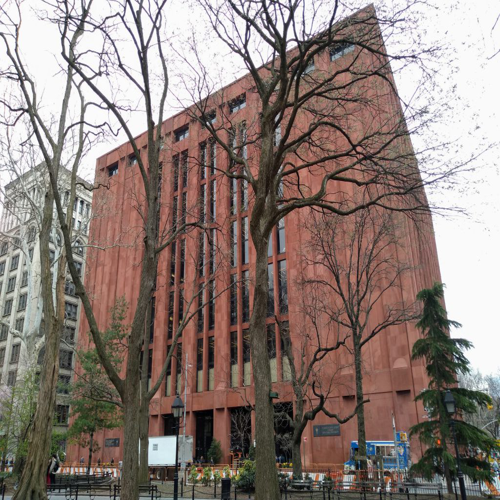

In [5]:
# target to be transformed
input_image = Image.open(input_image_path)
input_image = input_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
input_image

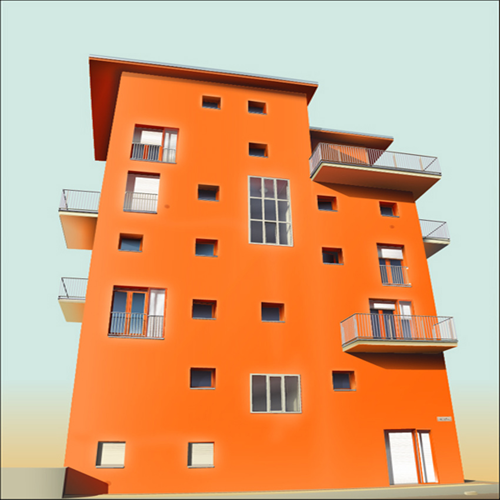

In [6]:
# style image
style_image = Image.open(style_image_path)
style_image = style_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
style_image

In [7]:
input_image_arr = np.asarray(input_image, dtype='float32')
input_image_arr = np.expand_dims(input_image_arr, axis=0)
input_image_arr[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
input_image_arr[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
input_image_arr[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
input_image_arr = input_image_arr[:, :, :, ::-1]
input_image = backend.variable(input_image_arr)


In [8]:
style_image_arr = np.asarray(style_image, dtype='float32')
style_image_arr = np.expand_dims(style_image_arr, axis=0)
style_image_arr[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
style_image_arr[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
style_image_arr[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
style_image_arr = style_image_arr[:, :, :, ::-1]
style_image = backend.variable(style_image_arr)

In [10]:
# Model design
transformed_image = backend.placeholder((1, IMAGE_HEIGHT, IMAGE_WIDTH, 3))
print(input_image_arr.shape, style_image.shape, transformed_image.shape)

model = VGG16(input_tensor=backend.concatenate([input_image, style_image, transformed_image], axis=0), include_top=False)

  <tf.Variable 'Variable:0' shape=(1, 500, 500, 3) dtype=float32>. This is a strong indication that the Lambda layer should be rewritten as a subclassed Layer.


(1, 500, 500, 3) (1, 500, 500, 3) (1, 500, 500, 3)


In [11]:
# model architecture
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(1, 500, 500, 3)]        0         
                                                                 
 tf.concat_1 (TFOpLambda)    (3, 500, 500, 3)          0         
                                                                 
 block1_conv1 (Conv2D)       (3, 500, 500, 64)         1792      
                                                                 
 block1_conv2 (Conv2D)       (3, 500, 500, 64)         36928     
                                                                 
 block1_pool (MaxPooling2D)  (3, 250, 250, 64)         0         
                                                                 
 block2_conv1 (Conv2D)       (3, 250, 250, 128)        73856     
                                                                 
 block2_conv2 (Conv2D)       (3, 250, 250, 128)        147584

In [12]:
def content_loss(model, content_layer_name, weight):
    content_layer_features = None
    for idx, layer in enumerate(model.layers):
        if layer.name == content_layer_name:
            content_layer_features = model.layers[idx].output
            break
    #print(content_layer_features)
    image_idx = 0
    combination_idx = 2
    image_features = content_layer_features[image_idx,:,:,:]
    combination_features = content_layer_features[combination_idx,:,:,:]
    l2_loss = weight * backend.sum(backend.square(combination_features - image_features))
    
    return l2_loss

loss = backend.variable(0.)
loss = loss + content_loss(model,"block2_conv2", CONTENT_WEIGHT)
#loss